# Heart Rate Analysis Plain Python

In [1]:
#Library Imports
import pandas as pd
import matplotlib.pyplot as plt
import math as maths
import numpy as np
from scipy.interpolate import interp1d
from scipy.signal import butter, lfilter

In [2]:
#Import Dataset
simple_hr_df = pd.read_csv("Data/bidmc_01_Signals(125hz).csv")
simple_hr_df.head(10)

,Time [s],RESP,PLETH,V,AVR,II
0,0.000,0.35386,0.43597,0.52549,0.30392,0.72549
1,0.008,0.35679,0.43206,0.51961,0.33529,0.67059
2,0.016,0.35875,0.42815,0.51569,0.37451,0.60980
3,0.024,0.36168,0.42424,0.50588,0.41961,0.55098
4,0.032,0.36364,0.42131,0.50980,0.44902,0.50000
5,0.040,0.36559,0.41838,0.50588,0.48039,0.45490
6,0.048,0.36657,0.41740,0.51569,0.50980,0.40980
7,0.056,0.36852,0.41642,0.51569,0.51961,0.39020
8,0.064,0.36852,0.41544,0.51961,0.53529,0.37451
9,0.072,0.36852,0.41447,0.51961,0.54510,0.35882


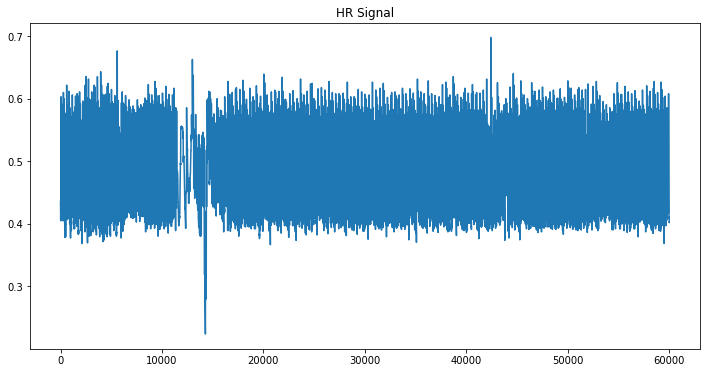

In [3]:
#Visulise HR Signal
plt.figure(figsize=(12,6))
plt.title("HR Signal")
plt.plot(simple_hr_df[" PLETH"])
plt.show()

## Detecting Peaks
- Find position of all R-Peaks
    - In order to do this we need to find the Regions of Intrest (ROI) 
        - Once ROI's are found, the maxima value in ROI is the Peak
        
#### Method: 
    -  draw a moving average, mark ROI’s where the heart rate signal lies above the moving average, and finally find the highest point in each ROI

In [4]:
# --- MOVING AVG ---
#Calc mov avg with 0.75s in both directions - appending to DF
#one-sided window size, proportion of sampling freq
hrw = 0.75
#100hz sample rate
fs = 125
#calc rolling avg on dataset
moving_avg = simple_hr_df[" PLETH"].rolling(int(hrw*fs)).mean()
#calc avg hr for beginning of signal 
avg_hr = (np.mean(simple_hr_df[" PLETH"]))
#add avg_hr to moving_avg for all values that are NaN
moving_avg = [avg_hr if x != x else x for x in moving_avg]
#Raise the average by 20% to prevent the secondary heart contraction from interfering
moving_avg = [x*1.2 for x in moving_avg] 
#Append the moving average to the dataframe
simple_hr_df['heart_rollingmean'] = moving_avg 

In [6]:
# --- MARK REGIONS OF INTREST ---
#Init lists to be used
window = []
peaklist = []
#iteratr
listpos = 0

#for each datapoint in signal
for x in simple_hr_df[" PLETH"]:
    #get local avg
    rolling_local_mean = simple_hr_df.heart_rollingmean[listpos]
    #if the datapoint is less than rolling mean and no points in ROI 
    #Must not be a ROI so increment counter
    if(x < rolling_local_mean) and (len(window) < 1):
        listpos += 1
    #if datapoint is above rolling avg then must be a ROI
    elif(x > rolling_local_mean):
        #add to ROI list
        window.append(x)
        #increment counter
        listpos += 1
# --- FIND MAX VALUE IN ROI (PEAK) ---
    #if datapoint is below rolling avg and the ROI list is greater than 1
    #signal must have dropped out of ROI
    else:
        #determine which point in ROI is the maximum value = Peak
        maximum_ROI_value = max(window)
        #determine position of peak in dataset
        peak_position = listpos - len(window) + (window.index(max(window)))
        #add peak_pos to list of peaks
        peaklist.append(peak_position)
        #Clear Window list of next ROI
        window = []
        #increment to next datapoint
        listpos += 1

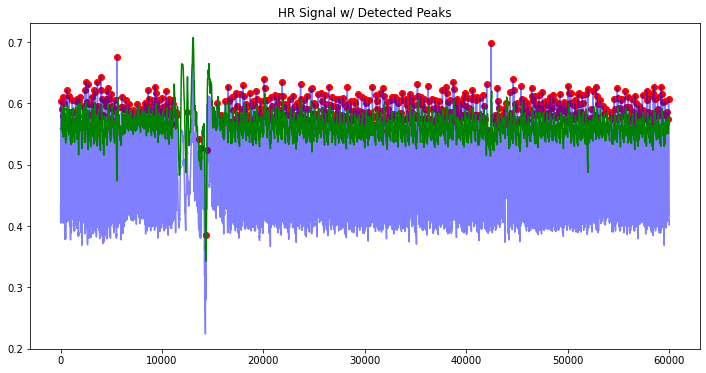

In [8]:
#Visualise Peaks on Signal
#find y-value of peaks in peaklist
y_pos_peak = [simple_hr_df[" PLETH"][x] for x in peaklist]

#plot it
plt.figure(figsize=(12,6))
plt.title("HR Signal w/ Detected Peaks")
plt.plot(simple_hr_df[" PLETH"], alpha=0.5, color='blue') #Plot semi-transparent HR
plt.plot(moving_avg, color ='green') #Plot moving average
plt.scatter(peaklist, y_pos_peak, color='red') #Plot detected peaks
plt.show()

### Calculating Heart Rate
- calculate the distance between the peaks, take the average and convert to a per minute value

In [9]:
#init list of distance between peaks
RR_list = []
#incrementer
inc = 0
#go through each peak in peak list
while(inc < len(peaklist)-1):
    #find distance between each peak
    RR_intvl = (peaklist[inc+1] - peaklist[inc])
    #convert distance to time
    ms_dist = ((RR_intvl/fs)*1000.0)
    #add it to list
    RR_list.append(ms_dist)
    #increment to next peak
    inc+=1

#calc bpm by dividing avg distance of peaks by 60000ms (1 min)
bpm = 60000/np.mean(RR_list)
print("BPM = %.01f" %bpm)

BPM = 79.5


## Extracting Complex Measure from HR Signal


In [10]:
# --- TIME DOMAIN MEASURES
#init lists of differences between all subsequent intervals between R-R pairs
RR_diff = []
#init lists of squared differences between all subsequent differences between R-R pairs
RR_sqdiff = []
#Use counter to iterate over RR_list
cnt = 1 
#Go thru each R-R intervals
while (cnt < (len(RR_list)-1)): 
    #Calculate absolute difference between successive R-R interval
    RR_diff.append(abs(RR_list[cnt] - RR_list[cnt+1])) 
    #Calculate squared difference
    RR_sqdiff.append(maths.pow(RR_list[cnt] - RR_list[cnt+1], 2)) 
    #increment to next interval
    cnt += 1

print(RR_diff, RR_sqdiff)

[8.0, 16.0, 8.0, 16.0, 8.0, 648.0, 648.0, 8.0, 16.0, 8.0, 8.0, 648.0, 672.0, 24.0, 632.0, 0.0, 632.0, 1280.0, 1288.0, 648.0, 656.0, 8.0, 24.0, 24.0, 0.0, 16.0, 0.0, 24.0, 16.0, 8.0, 24.0, 24.0, 0.0, 24.0, 8.0, 8.0, 8.0, 8.0, 8.0, 0.0, 8.0, 24.0, 16.0, 0.0, 8.0, 24.0, 0.0, 16.0, 8.0, 16.0, 16.0, 16.0, 0.0, 24.0, 32.0, 8.0, 8.0, 8.0, 672.0, 1992.0, 2664.0, 24.0, 0.0, 8.0, 16.0, 688.0, 672.0, 8.0, 8.0, 8.0, 16.0, 648.0, 648.0, 16.0, 8.0, 8.0, 8.0, 680.0, 688.0, 16.0, 16.0, 16.0, 24.0, 32.0, 8.0, 24.0, 16.0, 16.0, 0.0, 16.0, 16.0, 8.0, 8.0, 0.0, 16.0, 40.0, 32.0, 8.0, 0.0, 8.0, 16.0, 8.0, 8.0, 8.0, 16.0, 40.0, 40.0, 8.0, 32.0, 8.0, 8.0, 24.0, 16.0, 8.0, 8.0, 8.0, 16.0, 8.0, 16.0, 1280.0, 1280.0, 7224.0, 1840.0, 7744.0, 1272.0, 2384.0, 7448.0, 5688.0, 1968.0, 664.0, 640.0, 48.0, 2016.0, 2040.0, 88.0, 640.0, 688.0, 16.0, 0.0, 8.0, 0.0, 8.0, 0.0, 8.0, 16.0, 24.0, 32.0, 8.0, 0.0, 8.0, 16.0, 8.0, 24.0, 0.0, 16.0, 24.0, 56.0, 24.0, 16.0, 24.0, 32.0, 32.0, 24.0, 24.0, 16.0, 16.0, 32.0, 32.0, 8.0,

In [11]:
ibi = np.mean(RR_list) #Take the mean of RR_list to get the mean Inter Beat Interval
print("IBI:", ibi)

sdnn = np.std(RR_list) #Take standard deviation of all R-R intervals
print("SDNN:", sdnn)

sdsd = np.std(RR_diff) #Take standard deviation of the differences between all subsequent R-R intervals
print("SDSD:", sdsd)

rmssd = np.sqrt(np.mean(RR_sqdiff)) #Take root of the mean of the list of squared differences
print("RMSSD:", rmssd)

nn20 = [x for x in RR_diff if (x>20)] #First create a list of all values over 20, 50
nn50 = [x for x in RR_diff if (x>50)]
pnn20 = float(len(nn20)) / float(len(RR_diff)) #Calculate the proportion of NN20, NN50 intervals to all intervals
pnn50 = float(len(nn50)) / float(len(RR_diff)) #Note the use of float(), because we don't want Python to think we want an int() and round the proportion to 0 or 1
print("pNN20:", pnn20)
print("pNN50:", pnn50)

IBI: 754.4692913385827
SDNN: 610.2376975262795
SDSD: 646.3580405940554
RMSSD: 664.7115470324657
pNN20: 0.3412322274881517
pNN50: 0.12006319115323855


In [12]:
RR_x = peaklist[1:] #Remove the first entry, because first interval is assigned to the second beat.
RR_y = RR_list #Y-values are equal to interval lengths
RR_x_new = np.linspace(RR_x[0],RR_x[-1],RR_x[-1]) #Create evenly spaced timeline starting at the second peak, its endpoint and length equal to position of last peak
f = interp1d(RR_x, RR_y, kind='cubic') #Interpolate the signal with cubic spline interpolation

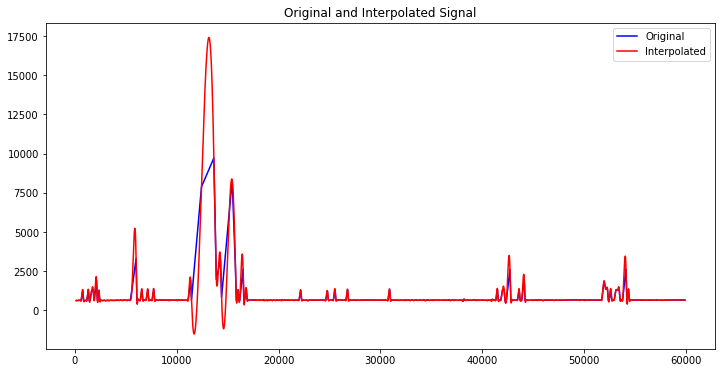

In [13]:
plt.figure(figsize=(12,6))
plt.title("Original and Interpolated Signal")
plt.plot(RR_x, RR_y, label="Original", color='blue')
plt.plot(RR_x_new, f(RR_x_new), label="Interpolated", color='red')
plt.legend()
plt.show()

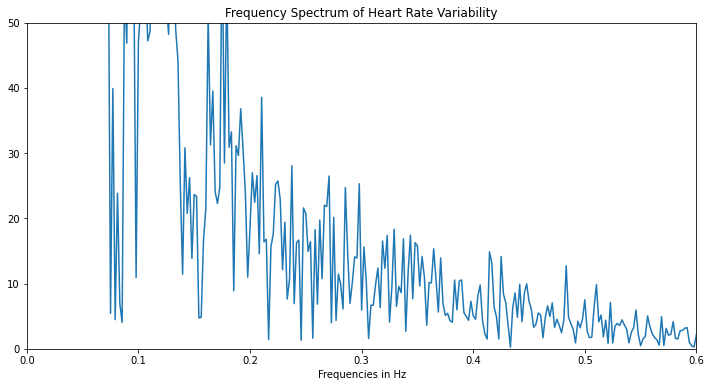

In [14]:
#Set variables
n = len(simple_hr_df[" PLETH"]) #Length of the signal
frq = np.fft.fftfreq(len(simple_hr_df[" PLETH"]), d=((1/fs))) #divide the bins into frequency categories
frq = frq[range(int(n/2))] #Get single side of the frequency range

#Do FFT
Y = np.fft.fft(f(RR_x_new))/n #Calculate FFT
Y = Y[range(int(n/2))] #Return one side of the FFT

#Plot
plt.figure(figsize=(12,6))
plt.title("Frequency Spectrum of Heart Rate Variability")
plt.xlim(0,0.6) #Limit X axis to frequencies of interest (0-0.6Hz for visibility, we are interested in 0.04-0.5)
plt.ylim(0, 50) #Limit Y axis for visibility
plt.plot(frq, abs(Y)) #Plot it
plt.xlabel("Frequencies in Hz")
plt.show()

In [15]:
lf = np.trapz(abs(Y[(frq>=0.04) & (frq<=0.15)])) #Slice frequency spectrum where x is between 0.04 and 0.15Hz (LF), and use NumPy's trapezoidal integration function to find the area
print("LF:", lf)

hf = np.trapz(abs(Y[(frq>=0.16) & (frq<=0.5)])) #Do the same for 0.16-0.5Hz (HF)
print("HF:", hf)

LF: 4522.413013501052
HF: 2099.482859578718
